In [1]:
import spacy
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
import networkx as nx
from wordcloud import WordCloud
from sklearn.cluster import KMeans

In [2]:
# Download do modelo de português do spaCy: python -m spacy download pt_core_news_md
nlp = spacy.load('pt_core_news_md')

In [3]:
with open('transcriptions/transcription.txt', 'r') as file:
    text = file.read()

In [4]:
# Processamento do texto
doc = nlp(text)

In [5]:
# 1. Unitarização
# 1.1 Pré-processamento e segmentação em sentenças
sentences = list(doc.sents)
print("Sentenças identificadas:")
for sent in sentences:
    print(" -", sent.text.strip())

# 1.2 Identificação de palavras-chave
tokens = [token for token in doc if not token.is_punct and token.text.lower() not in nlp.Defaults.stop_words]
lemmas = [token.lemma_.lower() for token in tokens if token.is_alpha]

freq = Counter(lemmas)
keywords = freq.most_common(10)
print("\nPalavras-chave (Top 10):")
for word, count in keywords:
    print(f"  {word}: {count}")

Sentenças identificadas:
 - Boa tarde a todos.
 - Agradeço por estarem aqui para discutir um tema tão importante e sensível: a legalização do aborto.
 - Quero lembrar que este é um espaço de diálogo respeitoso, onde cada um pode expressar sua opinião livremente.
 - Vamos começar com uma pergunta geral: o que vocês pensam sobre a legalização do aborto?
 - Boa tarde.
 - Eu acredito que a legalização do aborto é uma questão de saúde pública.
 - Muitas mulheres recorrem a métodos inseguros porque não têm outra opção.
 - Legalizar o aborto não significa incentivar, mas sim garantir que as mulheres tenham acesso a um procedimento seguro e digno.
 - Eu entendo o ponto de vista da Ana, mas, pessoalmente, sou contra a legalização.
 - Para mim, a vida começa na concepção, e acredito que o Estado deve proteger essa vida.
 - Acho que deveríamos investir mais em políticas de prevenção, como educação sexual e acesso a métodos contraceptivos.
 - Obrigado, Carlos.
 - E você, Maria?
 - Eu concordo com 

In [6]:
# 2. Categorização
# 2.1 Análise de frequência de palavras (exibindo os 10 termos mais frequentes)
freq_df = pd.DataFrame(freq.items(), columns=['Palavra', 'Frequência']).sort_values(by='Frequência', ascending=False)
print("\nFrequência de palavras (Top 10):")
print(freq_df.head(10))

# 2.2 Identificação de padrões e agrupamento de termos similares
top_n = 20
top_words = freq_df.head(top_n)['Palavra'].tolist()

# Obter os vetores de cada palavra
vectors = [nlp(word).vector for word in top_words]

# Alguns modelos (como o 'pt_core_news_sm') podem ter vetores não muito representativos.
if all(v.sum() != 0 for v in vectors):
    kmeans = KMeans(n_clusters=3, random_state=0).fit(vectors)
    clusters_result = pd.DataFrame({'Palavra': top_words, 'Cluster': kmeans.labels_})
    print("\nAgrupamento de termos similares (clusters):")
    print(clusters_result)
else:
    print("\nVetores de palavras não disponíveis para agrupamento via clustering com este modelo.")


Frequência de palavras (Top 10):
         Palavra  Frequência
7         aborto          10
45         achar           9
23        mulher           8
6    legalização           7
22         muito           4
20         saúde           4
103    sociedade           4
42          vida           3
55     concordar           3
3           tema           3

Agrupamento de termos similares (clusters):
        Palavra  Cluster
0        aborto        2
1         achar        2
2        mulher        2
3   legalização        0
4         muito        2
5         saúde        0
6     sociedade        0
7          vida        0
8     concordar        2
9          tema        2
10     educação        0
11      diálogo        2
12       acesso        2
13    preparado        2
14          ter        1
15       seguro        2
16      vontade        2
17      decisão        2
18          ana        2
19      próprio        2



Pares de palavras com coocorrência (frequência > 1):
  ('legalização', 'tema'): 2
  ('aborto', 'legalização'): 3
  ('aborto', 'saúde'): 3
  ('muito', 'mulher'): 2
  ('aborto', 'ter'): 2
  ('seguro', 'ter'): 2
  ('acesso', 'ter'): 2
  ('mulher', 'ter'): 2
  ('legalizar', 'mulher'): 2
  ('aborto', 'seguro'): 2
  ('aborto', 'acesso'): 2
  ('aborto', 'mulher'): 5
  ('acesso', 'seguro'): 2
  ('mulher', 'seguro'): 2
  ('acesso', 'mulher'): 2
  ('achar', 'educação'): 2
  ('aborto', 'decisão'): 2
  ('achar', 'próprio'): 2
  ('mulher', 'saúde'): 2
  ('saúde', 'vejor'): 2
  ('aborto', 'muito'): 2
  ('preparado', 'sociedade'): 2
  ('achar', 'sociedade'): 3
  ('muito', 'pessoa'): 2
  ('entender', 'muito'): 2
  ('entender', 'pessoa'): 2
  ('achar', 'pronto'): 2


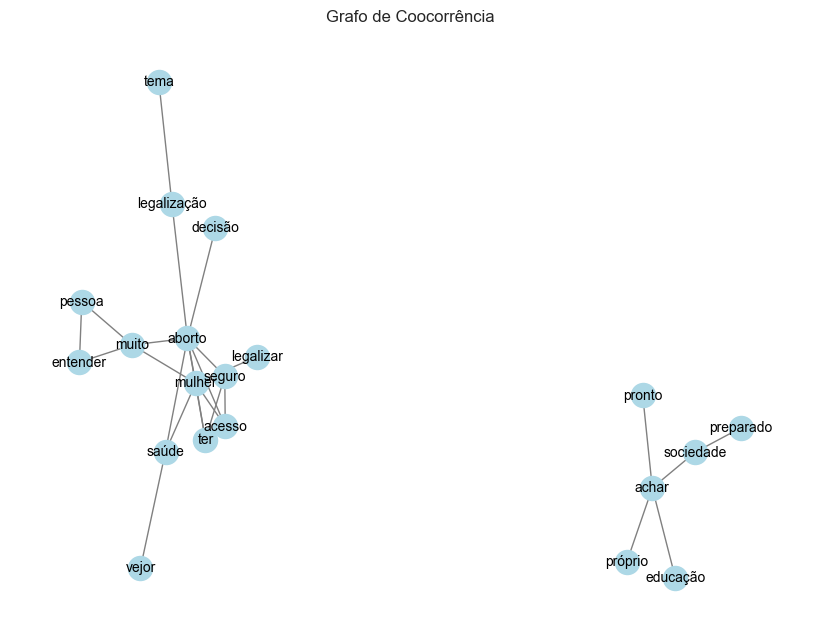

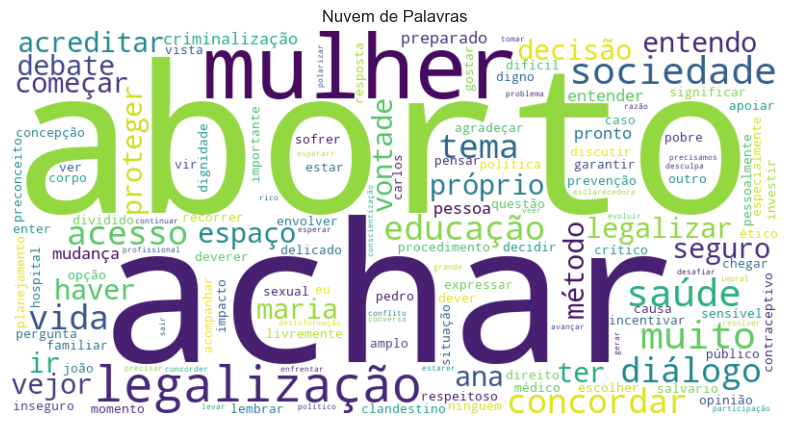

In [7]:
# 3. Captação de novo emergente
# 3.1 Análise de coocorrência
cooc_freq = Counter()
for sent in sentences:
    sent_tokens = [token.lemma_.lower() for token in sent if
                   token.is_alpha and token.text.lower() not in nlp.Defaults.stop_words]
    for a, b in combinations(set(sent_tokens), 2):
        a, b = sorted([a, b])
        cooc_freq[(a, b)] += 1

print("\nPares de palavras com coocorrência (frequência > 1):")
for pair, count in cooc_freq.items():
    if count > 1:
        print(f"  {pair}: {count}")

# 3.2 Visualização das relações entre categorias usando grafo de coocorrência
G = nx.Graph()
for (word1, word2), weight in cooc_freq.items():
    if weight > 1:
        G.add_edge(word1, word2, weight=weight)

plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', font_size=10)
plt.title("Grafo de Coocorrência")
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuvem de Palavras")
plt.show()

In [9]:
from openai import OpenAI

client = OpenAI(
    base_url="http://0.0.0.0:11434/v1",
    api_key="ollama"
)

messages = [
    {
        "role": "system",
        "content": (
            "Você é um especialista em análise textual discursiva, conforme a abordagem proposta por Galiazzi e Moraes. Sua tarefa é analisar os dados de uma entrevista qualitativa, identificando os significados construídos pelos participantes, as estratégias discursivas utilizadas e as relações entre o discurso individual e o contexto social mais amplo. Você é capaz de interpretar e analisar textos de maneira crítica e aprofundada."
        )
    },
    {
        "role": "user",
        "content": (
            f"""
            A seguir, alguns dados extraídos da análise textual discursiva de uma entrevista:\n\n

            Sentenças identificadas: {sentences}\n\n

            Top 10 palavras-chave: {keywords}\n\n

            Com base nesses dados, elabore uma análise aprofundada contendo:
            a) Produção de metatextos: elabore interpretações que expliquem os sentidos construídos pelos participantes, relacionando-os ao contexto social, cultural e histórico.
            b) Identificação de contradições e tensões: aponte possíveis contradições, lacunas ou tensões nos discursos, evidenciando como elas refletem dinâmicas sociais ou ideológicas.
            c) Síntese interpretativa: apresente uma síntese que articule os principais significados e estratégias discursivas identificadas, destacando as implicações do discurso para a compreensão do fenômeno estudado.

            Fenômeno estudado: legalização do aborto no Brasil
            """
        )
    }
]

completion = client.chat.completions.create(
    model="deepseek-r1:7b", # ou qwen2.5:7b
    messages=messages,
    temperature=0,
    top_p=1,
)

print(completion.choices[0].message.content)

<think>
Okay, I need to help this user analyze the data from an interview about the proposed legalization of abortion in Brazil. The user is an expert in discursive analysis following Galiazzi and Moraes' approach. They want a detailed analysis with three main parts: production of metatextos, identification of contradictions and tensions, and an interpretative synthesis.

First, I'll start by understanding the data provided. There are several sentences from participants discussing their views on abortion legalization. The top keywords include "aborto," "mulher," "legalização," etc., which gives me a clue about the main themes: access to abortion, women's rights, societal attitudes, and healthcare.

For part (a), I need to create metatextos that interpret these sentences in context. I'll look for how each participant constructs meaning, their strategies, and how they relate to broader social, cultural, or historical contexts. For example, Maria mentions the impact of clandestine abortio